In [13]:
import torch
from torch.utils.data import Dataset
import numpy as np
from statistics import mean

## Create dataset

In [14]:
import os
path_to_data = 'data/full'
individ_folders = sorted(os.listdir(path_to_data))

In [15]:
# Organise Samples
meta_testing_full_labels = np.load('data/meta_testing_full_labels.npy', allow_pickle=True).item()
full_list = os.listdir('data/full')

testing_list = [x[10:13] for x in meta_testing_full_labels['image']]
testing_list = sorted(list(set(testing_list)))

training_list = [y for y in full_list if y not in testing_list]
validation_list = testing_list[:-5]

In [16]:
validation_list

['001',
 '018',
 '023',
 '041',
 '049',
 '050',
 '060',
 '062',
 '064',
 '068',
 '069',
 '078',
 '083',
 '088',
 '090']

In [17]:
# Organise Labels
all_labels = sorted(os.listdir(os.path.join(path_to_data, '001', 'labels')))
list_of_interest = ['PELVIS', 'LIST', 'Pfannendach', 'Shenton', 'femur_cort_med_l', 'femur_cort_med_r','femur_cort_lat_l','femur_cort_lat_r', 'ilium', 'Linea', 'Ilioisch', 'Ball_Filled']
chosen_labels = [string for string in all_labels if any(substring in string for substring in list_of_interest)]
exclude = ['LIST_F32_l.npy', 'LIST_F32_r.npy', 'LIST_F36_l.npy', 'LIST_F36_r.npy', 'LIST_F37_l.npy', 'LIST_F37_r.npy', 'LIST_F38_l.npy', 'LIST_F38_r.npy', 'LIST_F39_l.npy', 'LIST_F39_r.npy', 'LIST_F40_l.npy', 'LIST_F40_r.npy', 'LIST_F41_l.npy', 'LIST_F41_r.npy', 'LIST_F42_l.npy', 'LIST_F42_r.npy', 'PELVIS_Isch_tuber_anter_l.npy', 'PELVIS_Isch_tuber_anter_r.npy']
chosen_labels = [lab for lab in chosen_labels if lab not in exclude]

def create_label_code(list_of_labels):
    d = {}
    for i, label in enumerate(list_of_labels):
        d[label] = i
    return d

def create_code_label(list_of_labels):
    d = {}
    for i, label in enumerate(list_of_labels):
        d[i] = label
    return d

label_code = create_label_code(chosen_labels)
code_label = create_code_label(chosen_labels)

def convert_label2code(label, label_code = label_code):
    code = label_code[label]
    return code

def convert_code2label(code, label_code=label_code):
    return next((key for key, val in label_code.items() if val == code), None)

In [18]:
len(chosen_labels)

77

In [19]:
with open('datasets/chosen_labels.txt', 'w') as f:
    for item in chosen_labels:
        f.write(f'{item} ')

In [20]:
if not os.path.isdir('datasets/yolo_full/train/images'):
    os.makedirs('datasets/yolo_full/train/images')
if not os.path.isdir('datasets/yolo_full/val/images'):
    os.makedirs('datasets/yolo_full/val/images')
if not os.path.isdir('datasets/yolo_full/test/images'):
    os.makedirs('datasets/yolo_full/test/images')

if not os.path.isdir('datasets/yolo_full/train/labels'):
    os.makedirs('datasets/yolo_full/train/labels')
if not os.path.isdir('datasets/yolo_full/val/labels'):
    os.makedirs('datasets/yolo_full/val/labels')
if not os.path.isdir('datasets/yolo_full/test/labels'):
    os.makedirs('datasets/yolo_full/test/labels')

In [21]:
from PIL import Image

def image_np2jpg(ind_id, input_path, output_folder):
    img_array = np.load(input_path)
    origImage =  img_array[img_array.files[0]]
    origImage = origImage*255/max(origImage.flatten())
    image = Image.fromarray(np.uint8(origImage)).convert('RGB')
    image.save(os.path.join(output_folder, f'{ind_id}.jpg'))
    return image 

In [22]:
#Get a bounding box from a mask.
def get_bounding_box(ground_truth_map):

  # define edges of the mask location
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - 10 - np.random.randint(0, 10))
  x_max = min(W, x_max + 10 + np.random.randint(0, 10))
  y_min = max(0, y_min - 10 - np.random.randint(0, 10))
  y_max = min(H, y_max + 10 + np.random.randint(0, 10))

  x_center = mean([x_min, x_max])
  y_center = mean([y_min, y_max])
  box_width = x_max - x_min
  box_height = y_max - y_min

  # create a normalized label:
  bbox = [x_center/W, y_center/H, box_width/W, box_height/H]

  return bbox

In [23]:
from concurrent.futures import ThreadPoolExecutor

train_output_folder = 'datasets/yolo_full/train'
val_output_folder = 'datasets/yolo_full/val'
test_output_folder = 'datasets/yolo_full/test'

def process_instance(ind, path_to_data, output_folder, chosen_labels):
    """Process a single training instance: convert image, generate labels, and save outputs."""
    # Convert image from npz to jpg and save it
    image_path = os.path.join(path_to_data, ind, 'image', ind + '.npz')
    image_np2jpg(ind, image_path, os.path.join(output_folder, 'images'))

    # Collect the output file name
    image_filename = f'{ind}.jpg'

    # Prepare the labels
    labels_output_path = os.path.join(output_folder, 'labels', f'{ind}.txt')
    with open(labels_output_path, 'w') as file:
        for label in chosen_labels:
            mask_path = os.path.join(path_to_data, ind, 'labels', f'{label}')
            if os.path.exists(mask_path):
                label_map = np.uint8(np.load(mask_path))
                bbox = get_bounding_box(label_map)
                code = convert_label2code(label)
                file.write(f'{code} {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}\n')

    #augment_brightness(ind, os.path.join(output_folder, 'images'), os.path.join(output_folder, 'labels'))

    # augment instance

    return image_filename

import cv2 as cv
import shutil

# def augment_brightness(ind, path_to_images, path_to_labels, count = 1):
#     # change image
#     img = cv.imread(os.path.join(path_to_images, f'{ind}.jpg'))
#     alpha = random(np.arange(0.1, 3.1,0.1), 1)
#     beta = random(np.arange(1, 101), 1)
#     new_image = cv.convertScaleAbs(img, alpha=alpha, beta=beta)
#     cv.imwrite(os.path.join(path_to_images, f'{ind}_br{count}.jpg'), new_image)
#     # clone labels
#     shutil.copy(os.path.join(path_to_labels, f'{ind}.txt'), os.path.join(path_to_labels, f'{ind}_br{count}.txt'))


def process_all(training, path_to_data, output_folder, chosen_labels):
    """Process all training data in parallel."""
    training_images_array = []
    
    with ThreadPoolExecutor() as executor:
        # Submit all tasks to the executor
        futures = [
            executor.submit(process_instance, ind, path_to_data, output_folder, chosen_labels)
            for ind in training
        ]

        # Collect results as they complete
        for future in futures:
            training_images_array.append(future.result())

    return training_images_array



In [24]:
# training
training_images_array = process_all(training_list, path_to_data, 'datasets/yolo_full/train', chosen_labels)
# validation
val_images_array = process_all(validation_list, path_to_data, 'datasets/yolo_full/val', chosen_labels)
# testing
testing_images_array = process_all(testing_list, path_to_data, 'datasets/yolo_full/test', chosen_labels)

## Preview an examle

In [13]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def parse_label(path_to_file):
    list_of_boxes = []
    with open(path_to_file) as f:
      for line in f:
         items = line.split()
         label = items[0]
         x_center = float(items[1])
         y_center = float(items[2])
         W = float(items[3])
         H = float(items[4])
         x0 = x_center - 0.5*W
         y0 = y_center - 0.5*H
         list_of_boxes.append([label, x0*1024, y0*1024, W*1024, H*1024])
    return list_of_boxes

def show_boxes(boxes_array, ax):
    for box in boxes_array:
        ax.add_patch(plt.Rectangle((box[1], box[2]), box[3], box[4], edgecolor='green', facecolor=(0,0,0,0), lw=2))
        ax.text(box[1], box[2], box[0], ha='center')  

def masked_label(label_array): 
    masked_data = np.ma.masked_where(label_array < 1, label_array)
    plt.imshow(masked_data, cmap=cm.autumn)

def show_boxes_on_image(raw_image, boxes, label_array):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    masked_label(label_array)
    show_boxes(boxes, plt.gca())
    plt.axis('on')
    plt.show()

In [16]:
training_images_array[1]

'026.jpg'

In [17]:
ind = training_images_array[1][:-4]

im = Image.open(f'datasets/yolo_full/train/images/{ind}.jpg')
boxes = parse_label(f'datasets/yolo_full/train/labels/{ind}.txt')

ind_labels = []
for i, mask in enumerate(chosen_labels):
    mask_path = os.path.join(path_to_data, ind, 'labels', f'{mask}')
    if os.path.exists(mask_path):
        label = np.uint8(np.load(mask_path))
        ind_labels.append(label)
        
label_array = np.sum(ind_labels, axis = 0)
label_array.shape

(1024, 1024)

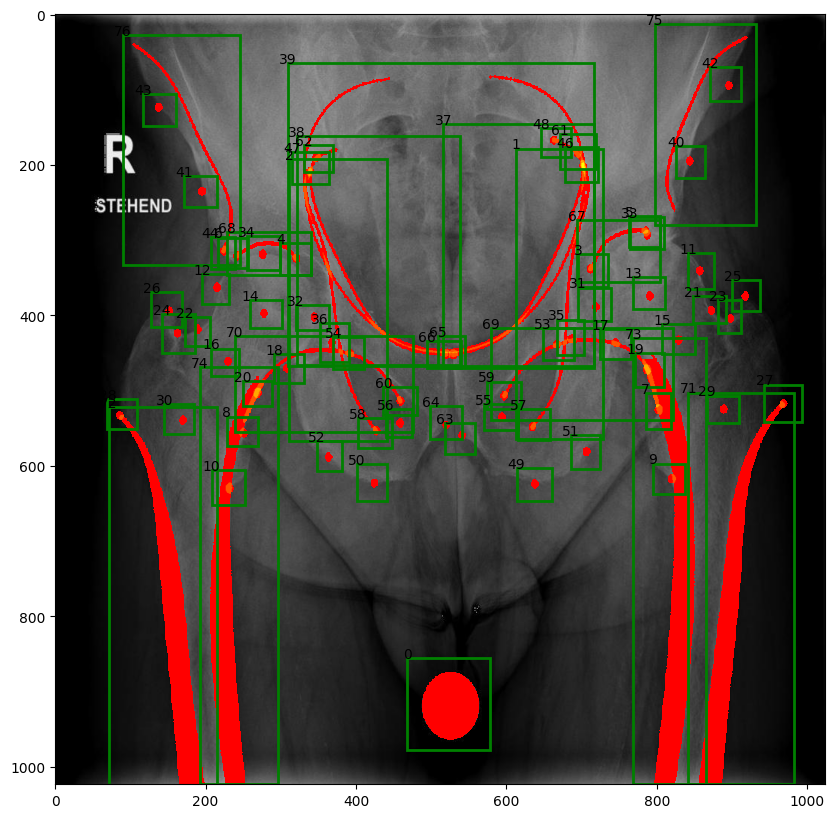

In [18]:
show_boxes_on_image(im, boxes, label_array)

In [19]:
import yaml
yam = {}
yam['path'] = 'yolo_full'
yam['train'] = 'train/images'
yam['val'] = 'val/images'
yam['names'] = code_label
with open('yolo_full_set.yaml', 'w') as yaml_file:
    yaml.dump(yam, yaml_file, default_flow_style=False)

In [20]:
# load pretrained model
from ultralytics import YOLO
model = YOLO("yolo11n.pt")

In [23]:
results = model.train(data="yolo_full_set.yaml", epochs=300, imgsz=640, degrees=10, hsv_v=0.3, fliplr=0.0, flipud=0.0, device=0, exist_ok=True)

New https://pypi.org/project/ultralytics/8.3.67 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.34 🚀 Python-3.10.15 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=yolo_full_set.yaml, epochs=300, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save

train: Scanning /home/katya/Huggingface/datasets/yolo_full/train/labels.cache... 80 images, 0 backgrounds, 0 corrupt: 100%|██████████| 80/80 [00:00<?, ?it/s]
val: Scanning /home/katya/Huggingface/datasets/yolo_full/val/labels.cache... 15 images, 0 backgrounds, 0 corrupt: 100%|██████████| 15/15 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000123, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300      8.92G      1.858      3.138      1.194       1479        640: 100%|██████████| 5/5 [00:13<00:00,  2.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.90it/s]

                   all         15       1134      0.445      0.323      0.342       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/300      6.46G      1.812      3.089      1.189       1809        640: 100%|██████████| 5/5 [00:10<00:00,  2.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.90it/s]

                   all         15       1134      0.467      0.324      0.344       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300      6.16G      1.827      3.104      1.189       1541        640: 100%|██████████| 5/5 [00:06<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

                   all         15       1134      0.473      0.314      0.353      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300      7.18G      1.864      3.121      1.192       1710        640: 100%|██████████| 5/5 [00:07<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.30s/it]

                   all         15       1134      0.497      0.307      0.349      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300      6.94G      1.829      3.104      1.219       1576        640: 100%|██████████| 5/5 [00:10<00:00,  2.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

                   all         15       1134      0.503      0.314      0.354      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300      7.16G      1.817      3.066      1.206       1754        640: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.22s/it]

                   all         15       1134       0.49      0.321      0.361      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300      7.07G      1.847      3.084      1.208       1329        640: 100%|██████████| 5/5 [00:07<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.16s/it]

                   all         15       1134      0.477       0.32      0.361      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300      6.51G      1.775      3.005      1.208       1661        640: 100%|██████████| 5/5 [00:09<00:00,  1.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.59s/it]

                   all         15       1134      0.473      0.322      0.367      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300      6.99G      1.814      2.984      1.213       1952        640: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

                   all         15       1134       0.47      0.325      0.369      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300       6.4G      1.868      2.952      1.207       1306        640: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

                   all         15       1134      0.476       0.34       0.37      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300       6.4G      1.875      3.005      1.207       1730        640: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]

                   all         15       1134      0.477      0.346      0.383       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/300      7.08G       1.84      2.985      1.225       1564        640: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

                   all         15       1134      0.481      0.359      0.392      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/300      7.13G      1.876      2.992      1.194       1874        640: 100%|██████████| 5/5 [00:09<00:00,  1.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

                   all         15       1134      0.484      0.356      0.391      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/300       6.6G      1.866      2.885       1.21       1521        640: 100%|██████████| 5/5 [00:08<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.59s/it]

                   all         15       1134      0.492      0.352      0.398       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/300      6.83G      1.866      2.887      1.224       1627        640: 100%|██████████| 5/5 [00:11<00:00,  2.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

                   all         15       1134        0.5      0.361      0.406      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/300      7.16G      1.839      2.843      1.264       1640        640: 100%|██████████| 5/5 [00:10<00:00,  2.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

                   all         15       1134      0.484       0.37      0.405        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/300      7.15G      1.896      2.808      1.197       1707        640: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

                   all         15       1134      0.527      0.364      0.419      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/300      6.66G      1.815      2.787      1.208       1558        640: 100%|██████████| 5/5 [00:11<00:00,  2.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.58s/it]

                   all         15       1134      0.525      0.351      0.412      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/300       6.4G      1.828      2.758      1.168       1726        640: 100%|██████████| 5/5 [00:09<00:00,  1.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all         15       1134      0.512      0.344      0.407      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/300      7.15G      1.828      2.763       1.19       1664        640: 100%|██████████| 5/5 [00:08<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.42s/it]

                   all         15       1134      0.516      0.358      0.428      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/300      7.23G      1.856      2.745      1.208       1888        640: 100%|██████████| 5/5 [00:11<00:00,  2.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

                   all         15       1134      0.485      0.376      0.434      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/300      6.64G      1.864      2.698      1.194       1335        640: 100%|██████████| 5/5 [00:08<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.49s/it]

                   all         15       1134       0.49      0.376      0.436      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/300      6.73G      1.844      2.692      1.223       1609        640: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]

                   all         15       1134      0.485      0.388      0.449      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/300      7.12G      1.828      2.679      1.193       1660        640: 100%|██████████| 5/5 [00:10<00:00,  2.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.29s/it]

                   all         15       1134      0.542      0.392      0.452      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/300      6.96G       1.85      2.662      1.223       1674        640: 100%|██████████| 5/5 [00:08<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

                   all         15       1134      0.539      0.391       0.45      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/300      6.37G      1.852      2.614      1.185       2098        640: 100%|██████████| 5/5 [00:07<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.94s/it]

                   all         15       1134      0.542      0.402      0.459      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/300      7.45G      1.843      2.624      1.188       1877        640: 100%|██████████| 5/5 [00:11<00:00,  2.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all         15       1134      0.503      0.422      0.471      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/300      6.31G      1.831       2.62      1.176       1758        640: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

                   all         15       1134      0.472      0.442      0.474      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/300      6.46G      1.814      2.623      1.224       2118        640: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.22s/it]

                   all         15       1134      0.482      0.441      0.479      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/300      6.37G      1.881      2.657      1.233       1634        640: 100%|██████████| 5/5 [00:06<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

                   all         15       1134      0.484      0.441      0.482       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/300      6.45G      1.774      2.538      1.207       2011        640: 100%|██████████| 5/5 [00:06<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.95s/it]

                   all         15       1134      0.486      0.438      0.482       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/300      6.44G      1.782      2.526      1.167       1875        640: 100%|██████████| 5/5 [00:07<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

                   all         15       1134      0.515       0.44      0.488      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/300      6.73G      1.776      2.464      1.198       1201        640: 100%|██████████| 5/5 [00:07<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

                   all         15       1134      0.507      0.448      0.491      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/300      7.47G      1.809      2.524      1.166       1928        640: 100%|██████████| 5/5 [00:10<00:00,  2.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

                   all         15       1134       0.51      0.456      0.495      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/300      7.16G      1.776      2.432      1.194       1366        640: 100%|██████████| 5/5 [00:09<00:00,  1.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.77s/it]

                   all         15       1134       0.51      0.462      0.498      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/300      7.37G      1.743      2.377      1.207       1609        640: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

                   all         15       1134        0.5      0.471      0.499      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/300       7.5G      1.802      2.382      1.202       1574        640: 100%|██████████| 5/5 [00:11<00:00,  2.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.76s/it]

                   all         15       1134      0.493      0.479      0.509      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/300      6.69G      1.804      2.434      1.189       1455        640: 100%|██████████| 5/5 [00:09<00:00,  1.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.69s/it]

                   all         15       1134      0.491       0.49      0.519      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/300      7.27G      1.772      2.386      1.199       1755        640: 100%|██████████| 5/5 [00:09<00:00,  1.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.91s/it]

                   all         15       1134      0.507       0.49       0.53      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/300      6.75G      1.796      2.388      1.202       1564        640: 100%|██████████| 5/5 [00:11<00:00,  2.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

                   all         15       1134      0.513      0.508      0.528      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/300      6.45G      1.771      2.329       1.19       1563        640: 100%|██████████| 5/5 [00:10<00:00,  2.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

                   all         15       1134       0.52      0.515      0.537      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/300      6.99G      1.774      2.373      1.187       2030        640: 100%|██████████| 5/5 [00:08<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

                   all         15       1134      0.557      0.521      0.556      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/300      6.72G      1.749      2.289      1.188       1563        640: 100%|██████████| 5/5 [00:10<00:00,  2.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all         15       1134      0.558      0.516      0.558      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/300      6.38G      1.744      2.291      1.185       1612        640: 100%|██████████| 5/5 [00:09<00:00,  1.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all         15       1134      0.556      0.511      0.552      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/300      7.08G      1.796      2.292       1.19       2384        640: 100%|██████████| 5/5 [00:10<00:00,  2.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

                   all         15       1134      0.553       0.51      0.559      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/300       6.7G      1.752      2.269      1.191       1672        640: 100%|██████████| 5/5 [00:10<00:00,  2.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

                   all         15       1134      0.566       0.51      0.566      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/300      6.93G      1.761       2.22       1.17       1662        640: 100%|██████████| 5/5 [00:08<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

                   all         15       1134      0.565      0.517      0.571      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/300      7.05G      1.762      2.206      1.188       1980        640: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all         15       1134      0.565      0.522      0.573      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/300      7.21G      1.829      2.249      1.198       1542        640: 100%|██████████| 5/5 [00:10<00:00,  2.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.55s/it]

                   all         15       1134      0.563      0.526      0.575      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/300      7.03G      1.753      2.147      1.185       2013        640: 100%|██████████| 5/5 [00:08<00:00,  1.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.78s/it]

                   all         15       1134      0.564      0.529       0.58      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/300      6.44G      1.741      2.154      1.154       1560        640: 100%|██████████| 5/5 [00:09<00:00,  1.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all         15       1134      0.577      0.535      0.585      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/300      6.47G      1.705      2.113      1.159       1272        640: 100%|██████████| 5/5 [00:12<00:00,  2.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

                   all         15       1134      0.582      0.546       0.59      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/300      6.55G      1.728      2.123      1.158       1741        640: 100%|██████████| 5/5 [00:09<00:00,  1.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.68s/it]

                   all         15       1134      0.596      0.551      0.597      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/300      8.17G      1.701      2.076      1.166       1533        640: 100%|██████████| 5/5 [00:11<00:00,  2.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all         15       1134      0.594      0.558      0.598      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/300      6.85G       1.69      2.055      1.171       1588        640: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all         15       1134      0.585      0.565      0.605      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/300      7.18G      1.754      2.101      1.172       1914        640: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.40s/it]

                   all         15       1134      0.581      0.583      0.608      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/300      7.87G      1.698      2.013      1.181       1316        640: 100%|██████████| 5/5 [00:11<00:00,  2.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

                   all         15       1134      0.588      0.579      0.615      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/300      6.97G       1.73      2.046      1.183       1813        640: 100%|██████████| 5/5 [00:07<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.83s/it]

                   all         15       1134      0.587      0.578      0.615       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/300      7.13G      1.728      2.037      1.167       1479        640: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.92s/it]

                   all         15       1134       0.58      0.579      0.621      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/300      7.55G      1.716      2.019      1.159       1785        640: 100%|██████████| 5/5 [00:13<00:00,  2.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all         15       1134      0.593       0.56      0.606      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/300       8.2G      1.728      2.015      1.141       2026        640: 100%|██████████| 5/5 [00:16<00:00,  3.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.55s/it]

                   all         15       1134      0.583      0.554      0.598        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/300      6.59G      1.723      1.975      1.169       1995        640: 100%|██████████| 5/5 [00:09<00:00,  1.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.74s/it]

                   all         15       1134      0.608      0.568      0.608      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/300       6.3G      1.703      1.987      1.159       1711        640: 100%|██████████| 5/5 [00:08<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

                   all         15       1134      0.616      0.577      0.623      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/300      6.25G      1.656      1.924      1.149       1634        640: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

                   all         15       1134      0.632      0.596      0.633      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/300      6.42G        1.7      1.952      1.178       1403        640: 100%|██████████| 5/5 [00:07<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

                   all         15       1134      0.634      0.601      0.635      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/300      7.23G      1.684      1.904      1.171       2041        640: 100%|██████████| 5/5 [00:08<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

                   all         15       1134      0.634      0.609      0.638      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/300      6.92G      1.687      1.915      1.163       1587        640: 100%|██████████| 5/5 [00:09<00:00,  1.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all         15       1134      0.634      0.606      0.644       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/300       6.6G      1.684      1.874      1.186       1471        640: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.96s/it]

                   all         15       1134      0.631       0.61      0.646      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/300      7.01G      1.656      1.854      1.158       1566        640: 100%|██████████| 5/5 [00:10<00:00,  2.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

                   all         15       1134      0.635      0.617      0.656       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/300      6.16G      1.671      1.852      1.154       1094        640: 100%|██████████| 5/5 [00:06<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all         15       1134      0.646      0.624      0.662       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/300      7.58G      1.681      1.907      1.161       1351        640: 100%|██████████| 5/5 [00:07<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  3.00s/it]

                   all         15       1134      0.645      0.631      0.662      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/300      7.01G      1.686      1.889      1.156       1686        640: 100%|██████████| 5/5 [00:07<00:00,  1.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

                   all         15       1134      0.653      0.626      0.668      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/300       6.3G      1.652      1.821      1.186       1434        640: 100%|██████████| 5/5 [00:09<00:00,  1.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

                   all         15       1134      0.652       0.63      0.665      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/300      7.03G      1.676      1.796      1.152       1743        640: 100%|██████████| 5/5 [00:06<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.00s/it]

                   all         15       1134      0.657      0.637      0.678      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/300      6.57G      1.661      1.826      1.135       1649        640: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.98s/it]

                   all         15       1134      0.661      0.648       0.68       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/300      7.01G      1.671      1.815      1.141       1297        640: 100%|██████████| 5/5 [00:06<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.63s/it]

                   all         15       1134      0.667      0.655      0.687      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/300      6.39G      1.637       1.81      1.162       1338        640: 100%|██████████| 5/5 [00:08<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

                   all         15       1134      0.669      0.648      0.689      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/300      6.64G      1.741      1.817      1.158       1683        640: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.03s/it]

                   all         15       1134      0.662      0.652      0.683      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/300      6.99G      1.639      1.753      1.127       1732        640: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all         15       1134      0.655      0.653      0.675       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/300      7.57G      1.669      1.764      1.147       2135        640: 100%|██████████| 5/5 [00:11<00:00,  2.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.86s/it]

                   all         15       1134      0.655      0.655      0.679      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/300      7.26G      1.663      1.773      1.106       1768        640: 100%|██████████| 5/5 [00:08<00:00,  1.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.83s/it]

                   all         15       1134      0.652      0.663      0.685      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/300      6.97G      1.636      1.731      1.143       1896        640: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.51s/it]

                   all         15       1134      0.658      0.664      0.692      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/300      6.42G      1.646       1.75      1.134       1641        640: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

                   all         15       1134      0.666      0.662      0.693      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/300      6.85G       1.64       1.73      1.143       2038        640: 100%|██████████| 5/5 [00:08<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

                   all         15       1134      0.674      0.666      0.694      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/300      6.89G      1.645       1.74      1.155       1493        640: 100%|██████████| 5/5 [00:09<00:00,  1.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.60s/it]

                   all         15       1134      0.674       0.67      0.694      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/300      6.48G      1.607      1.676      1.132       1786        640: 100%|██████████| 5/5 [00:09<00:00,  1.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

                   all         15       1134       0.67      0.673      0.701      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/300      7.64G      1.647      1.688      1.132       1910        640: 100%|██████████| 5/5 [00:09<00:00,  1.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

                   all         15       1134       0.67       0.67      0.701      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/300      7.22G      1.624      1.676       1.13       1846        640: 100%|██████████| 5/5 [00:11<00:00,  2.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.78s/it]

                   all         15       1134      0.676      0.676      0.709       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/300      7.12G      1.624      1.681       1.16       1409        640: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.96s/it]

                   all         15       1134      0.681      0.679      0.708       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/300       6.8G      1.616       1.66      1.149       1931        640: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

                   all         15       1134      0.685      0.681      0.709      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/300      6.83G      1.634      1.657      1.137       1903        640: 100%|██████████| 5/5 [00:06<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all         15       1134       0.68      0.682      0.709      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/300      6.32G      1.625      1.653      1.177       1385        640: 100%|██████████| 5/5 [00:11<00:00,  2.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

                   all         15       1134       0.68      0.684      0.708      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/300      6.58G      1.617      1.643       1.13       1326        640: 100%|██████████| 5/5 [00:07<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.78s/it]

                   all         15       1134      0.669      0.673      0.698      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/300      7.16G      1.632      1.635      1.171       2287        640: 100%|██████████| 5/5 [00:06<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.82s/it]

                   all         15       1134      0.668      0.676      0.702      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/300      6.56G      1.638      1.607      1.137       1943        640: 100%|██████████| 5/5 [00:11<00:00,  2.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.92s/it]

                   all         15       1134      0.668      0.689      0.712      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/300      6.55G      1.599      1.615      1.152       1840        640: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.78s/it]

                   all         15       1134      0.683      0.693      0.719      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/300      6.58G      1.596      1.599      1.136       1536        640: 100%|██████████| 5/5 [00:06<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.80s/it]

                   all         15       1134      0.673      0.704      0.718      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/300      6.95G      1.661      1.636      1.161       1852        640: 100%|██████████| 5/5 [00:09<00:00,  1.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.75s/it]

                   all         15       1134      0.671      0.698       0.72      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/300      6.44G      1.609      1.579      1.137       1357        640: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.88s/it]

                   all         15       1134      0.659      0.694      0.712      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/300      6.96G      1.605      1.563       1.15       1310        640: 100%|██████████| 5/5 [00:06<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

                   all         15       1134      0.662       0.71       0.72      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/300      6.32G      1.629      1.589      1.119       2190        640: 100%|██████████| 5/5 [00:10<00:00,  2.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

                   all         15       1134      0.666      0.706      0.724      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/300      6.53G      1.582      1.541      1.126       1690        640: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.29s/it]

                   all         15       1134      0.665      0.715      0.725       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/300      6.46G      1.588      1.546        1.1       2080        640: 100%|██████████| 5/5 [00:07<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

                   all         15       1134      0.658      0.719       0.72      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/300      6.65G      1.598      1.553      1.137       1749        640: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.13s/it]

                   all         15       1134      0.662      0.707      0.708      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/300      6.32G      1.613      1.518      1.163       1330        640: 100%|██████████| 5/5 [00:10<00:00,  2.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

                   all         15       1134      0.673      0.715      0.712       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/300      6.34G      1.612      1.581      1.153       1304        640: 100%|██████████| 5/5 [00:06<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all         15       1134      0.682      0.721      0.729      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/300         7G      1.604      1.566      1.147       1464        640: 100%|██████████| 5/5 [00:08<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all         15       1134      0.681      0.711      0.727      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/300      6.37G      1.579       1.54      1.112       1507        640: 100%|██████████| 5/5 [00:11<00:00,  2.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all         15       1134      0.677      0.717       0.72      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/300      7.16G      1.582      1.536      1.114       1722        640: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.85s/it]

                   all         15       1134       0.68       0.72      0.722      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/300      7.98G      1.576       1.54      1.116       2179        640: 100%|██████████| 5/5 [00:11<00:00,  2.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

                   all         15       1134      0.681      0.722      0.725      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/300      6.82G      1.549      1.454      1.155       1619        640: 100%|██████████| 5/5 [00:10<00:00,  2.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

                   all         15       1134      0.688      0.732       0.73      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/300      7.01G      1.554      1.494      1.117       1775        640: 100%|██████████| 5/5 [00:09<00:00,  1.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

                   all         15       1134      0.692      0.732      0.732      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/300      6.57G      1.604       1.51      1.146       1297        640: 100%|██████████| 5/5 [00:06<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.57s/it]

                   all         15       1134      0.673      0.722      0.724      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/300      6.31G      1.567      1.502      1.123       1760        640: 100%|██████████| 5/5 [00:07<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.27s/it]

                   all         15       1134       0.67      0.721      0.724      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/300      6.61G      1.547      1.461      1.156       1342        640: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]

                   all         15       1134      0.672      0.718      0.725      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/300      6.55G      1.571      1.462      1.135       1794        640: 100%|██████████| 5/5 [00:08<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]

                   all         15       1134      0.692      0.725      0.737      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/300      7.19G      1.569       1.47      1.144       1802        640: 100%|██████████| 5/5 [00:16<00:00,  3.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

                   all         15       1134      0.689       0.72      0.732      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/300      7.38G      1.595      1.506      1.124       2204        640: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

                   all         15       1134      0.683      0.713      0.724      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/300      7.01G      1.587      1.513      1.124       1741        640: 100%|██████████| 5/5 [00:11<00:00,  2.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

                   all         15       1134       0.68      0.696      0.718      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/300      7.11G      1.591      1.518      1.151       2084        640: 100%|██████████| 5/5 [00:06<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

                   all         15       1134      0.688       0.72      0.737      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/300       6.5G      1.556      1.434      1.135       1589        640: 100%|██████████| 5/5 [00:09<00:00,  1.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all         15       1134      0.696      0.737      0.745      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/300       6.3G      1.541      1.463      1.137       1538        640: 100%|██████████| 5/5 [00:09<00:00,  1.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]

                   all         15       1134      0.707      0.727      0.747      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/300       7.1G      1.578      1.451      1.117       1536        640: 100%|██████████| 5/5 [00:11<00:00,  2.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.87s/it]

                   all         15       1134      0.706      0.717      0.742      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/300      7.36G      1.561      1.433      1.115       1831        640: 100%|██████████| 5/5 [00:08<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

                   all         15       1134      0.692      0.709      0.728      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/300       6.5G       1.57       1.44      1.129       1548        640: 100%|██████████| 5/5 [00:08<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.76s/it]

                   all         15       1134       0.68       0.71      0.726      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/300      6.58G      1.567      1.456      1.144       1492        640: 100%|██████████| 5/5 [00:08<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

                   all         15       1134      0.688      0.713      0.728      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/300      6.43G       1.55      1.447       1.12       1888        640: 100%|██████████| 5/5 [00:08<00:00,  1.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

                   all         15       1134      0.696      0.725      0.739      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/300      6.29G      1.575      1.463      1.133       1923        640: 100%|██████████| 5/5 [00:08<00:00,  1.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

                   all         15       1134      0.717      0.734       0.75      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/300      6.83G      1.596      1.412      1.153       1524        640: 100%|██████████| 5/5 [00:11<00:00,  2.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

                   all         15       1134      0.717      0.734       0.75      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/300      7.07G      1.565      1.428      1.127       1245        640: 100%|██████████| 5/5 [00:08<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

                   all         15       1134      0.717      0.726      0.746      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/300      6.96G      1.578      1.416      1.108       1776        640: 100%|██████████| 5/5 [00:08<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

                   all         15       1134      0.707      0.731      0.744       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/300      6.38G      1.555      1.411       1.14       1462        640: 100%|██████████| 5/5 [00:10<00:00,  2.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all         15       1134      0.686       0.72       0.73      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/300      7.24G      1.519      1.377      1.116       1642        640: 100%|██████████| 5/5 [00:08<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

                   all         15       1134      0.682      0.719      0.728      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/300      6.59G      1.546      1.422      1.121       1402        640: 100%|██████████| 5/5 [00:07<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.32s/it]

                   all         15       1134      0.691      0.712      0.731      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/300       6.7G      1.577      1.453      1.105       1941        640: 100%|██████████| 5/5 [00:08<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.97s/it]

                   all         15       1134      0.694      0.722      0.745      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/300      6.63G      1.558      1.402      1.109       1468        640: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]

                   all         15       1134      0.715      0.743      0.758      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/300      6.56G      1.582      1.453      1.132       1928        640: 100%|██████████| 5/5 [00:08<00:00,  1.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

                   all         15       1134      0.713      0.738      0.753      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/300      6.86G      1.526      1.425      1.132       1865        640: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

                   all         15       1134      0.706      0.732      0.748      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/300      6.77G      1.534      1.425      1.135       1365        640: 100%|██████████| 5/5 [00:08<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]

                   all         15       1134      0.699      0.727      0.745       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/300      7.04G      1.572      1.416      1.096       1690        640: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]

                   all         15       1134      0.699      0.732      0.742      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/300      7.13G      1.521      1.345      1.119       1446        640: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]

                   all         15       1134      0.699      0.732      0.744      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/300      7.02G      1.533      1.411      1.111       1872        640: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

                   all         15       1134      0.703       0.74      0.747      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/300      6.59G      1.514       1.38      1.138       2089        640: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.36s/it]

                   all         15       1134      0.704      0.738      0.747       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/300      6.31G       1.53      1.418      1.136       1626        640: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all         15       1134       0.71      0.739      0.747      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/300      6.56G      1.514      1.378      1.115       1906        640: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.98s/it]

                   all         15       1134      0.707      0.733      0.742      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/300      6.48G      1.535      1.396      1.101       1738        640: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.19s/it]

                   all         15       1134      0.706      0.729      0.743      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/300      7.36G      1.536        1.4      1.111       1812        640: 100%|██████████| 5/5 [00:10<00:00,  2.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

                   all         15       1134      0.687      0.735      0.742      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/300      6.39G      1.513       1.37      1.117       1592        640: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all         15       1134      0.702      0.747       0.75      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/300      7.47G      1.514       1.34      1.096       1833        640: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.87s/it]

                   all         15       1134      0.702      0.745      0.749       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/300      6.92G      1.539      1.382      1.104       1822        640: 100%|██████████| 5/5 [00:13<00:00,  2.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

                   all         15       1134      0.696      0.748      0.746       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/300      7.44G      1.567       1.38      1.116       1321        640: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

                   all         15       1134      0.703       0.74      0.748      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/300      6.64G      1.532      1.381      1.127       1423        640: 100%|██████████| 5/5 [00:09<00:00,  1.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.53s/it]

                   all         15       1134      0.714      0.742      0.751       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/300      6.34G        1.5      1.334      1.093       1795        640: 100%|██████████| 5/5 [00:11<00:00,  2.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

                   all         15       1134      0.707      0.745      0.752      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/300       6.5G      1.541       1.38      1.075       2062        640: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.24s/it]

                   all         15       1134      0.709      0.743       0.75      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/300      7.03G      1.496      1.327      1.126       1800        640: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.98s/it]

                   all         15       1134      0.706      0.734      0.744      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/300      7.22G      1.508      1.366      1.132       1463        640: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

                   all         15       1134      0.695      0.745      0.745      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/300      7.54G      1.502      1.352      1.106       1486        640: 100%|██████████| 5/5 [00:09<00:00,  1.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

                   all         15       1134      0.699       0.74      0.745      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/300      6.96G       1.54      1.348      1.127       1907        640: 100%|██████████| 5/5 [00:09<00:00,  1.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

                   all         15       1134      0.698      0.739      0.748      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/300      6.56G      1.528      1.335      1.128       1307        640: 100%|██████████| 5/5 [00:09<00:00,  1.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]

                   all         15       1134      0.696      0.739      0.748      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/300      6.45G      1.495      1.279      1.107       1310        640: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

                   all         15       1134      0.709      0.721       0.74      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/300      7.26G      1.504      1.304      1.108       1923        640: 100%|██████████| 5/5 [00:06<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all         15       1134      0.717       0.72      0.742      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/300      7.24G        1.5      1.321      1.118       1657        640: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

                   all         15       1134      0.721      0.719      0.745      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/300       7.2G      1.502       1.32      1.131       1444        640: 100%|██████████| 5/5 [00:11<00:00,  2.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.19s/it]

                   all         15       1134      0.722      0.735      0.751      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/300      6.67G      1.528      1.308      1.109       1431        640: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.24s/it]

                   all         15       1134      0.726       0.74      0.757       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/300      7.67G       1.55      1.322      1.119       2142        640: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

                   all         15       1134      0.724      0.729      0.754       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/300      6.63G      1.581       1.42      1.096       1964        640: 100%|██████████| 5/5 [00:10<00:00,  2.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]

                   all         15       1134      0.716      0.728      0.748      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/300      7.42G      1.512      1.322      1.106       1872        640: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

                   all         15       1134      0.702      0.726      0.738      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/300      6.56G      1.552      1.363      1.126       1934        640: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.60s/it]

                   all         15       1134      0.702      0.732      0.741      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/300      6.65G      1.488      1.289      1.115       1634        640: 100%|██████████| 5/5 [00:10<00:00,  2.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

                   all         15       1134      0.711      0.733      0.748      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/300      6.59G      1.478      1.289      1.115       1518        640: 100%|██████████| 5/5 [00:06<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all         15       1134      0.723      0.747      0.763      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/300      6.86G      1.534      1.268      1.094       1536        640: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all         15       1134      0.738      0.742      0.769      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/300      6.59G       1.52       1.29      1.122       1361        640: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]

                   all         15       1134      0.738      0.759      0.774      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/300      6.86G      1.511      1.287      1.102       1856        640: 100%|██████████| 5/5 [00:08<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

                   all         15       1134       0.73      0.761      0.768      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/300      7.02G      1.476      1.286      1.118       1146        640: 100%|██████████| 5/5 [00:09<00:00,  1.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all         15       1134      0.709      0.755      0.756      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/300      6.48G      1.467      1.266      1.106       1788        640: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.30s/it]

                   all         15       1134      0.701      0.757      0.748      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/300      6.49G      1.499      1.273      1.095       1942        640: 100%|██████████| 5/5 [00:12<00:00,  2.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.69s/it]

                   all         15       1134      0.693      0.756      0.751      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/300      7.73G      1.497       1.29      1.089       1896        640: 100%|██████████| 5/5 [00:10<00:00,  2.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

                   all         15       1134      0.715       0.76      0.761      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/300      6.61G      1.466      1.266      1.085       1997        640: 100%|██████████| 5/5 [00:10<00:00,  2.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

                   all         15       1134      0.716      0.761      0.765      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/300       6.7G      1.451      1.257      1.126       1527        640: 100%|██████████| 5/5 [00:08<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

                   all         15       1134      0.718      0.758      0.768      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/300      6.32G      1.474      1.279      1.126       1530        640: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

                   all         15       1134      0.727      0.756      0.773      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/300      6.87G      1.487       1.28      1.103       1560        640: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

                   all         15       1134      0.719      0.753      0.766        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/300      6.25G      1.471      1.241      1.118       1470        640: 100%|██████████| 5/5 [00:09<00:00,  1.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]

                   all         15       1134      0.715      0.746      0.759      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/300      6.52G        1.5      1.321      1.089       1774        640: 100%|██████████| 5/5 [00:06<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]

                   all         15       1134        0.7       0.75      0.756      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/300      7.14G      1.471      1.281      1.093       1539        640: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.97s/it]

                   all         15       1134      0.697      0.746      0.753      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/300      7.16G      1.504      1.312      1.101       1823        640: 100%|██████████| 5/5 [00:10<00:00,  2.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.02s/it]

                   all         15       1134      0.709      0.749      0.764      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/300      6.33G      1.483       1.26      1.103       1468        640: 100%|██████████| 5/5 [00:07<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

                   all         15       1134      0.725      0.744       0.77      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/300      6.52G      1.481      1.233      1.097       1831        640: 100%|██████████| 5/5 [00:06<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.61s/it]

                   all         15       1134      0.734      0.745      0.775      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/300      6.48G       1.49      1.245      1.112       1200        640: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

                   all         15       1134      0.727      0.752      0.772      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/300      7.12G      1.495      1.274      1.098       1461        640: 100%|██████████| 5/5 [00:09<00:00,  1.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

                   all         15       1134      0.718      0.748      0.766        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/300      6.57G      1.529      1.324      1.131       1398        640: 100%|██████████| 5/5 [00:06<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.48s/it]

                   all         15       1134      0.716      0.752      0.764      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/300      6.98G      1.435       1.23      1.082       1636        640: 100%|██████████| 5/5 [00:07<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

                   all         15       1134      0.717      0.749      0.762      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/300      6.94G      1.478      1.265      1.095       1742        640: 100%|██████████| 5/5 [00:07<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

                   all         15       1134      0.732      0.756      0.773      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/300      6.32G      1.466      1.229      1.133       1678        640: 100%|██████████| 5/5 [00:10<00:00,  2.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

                   all         15       1134      0.733      0.756      0.774      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/300      6.55G      1.564      1.289      1.108       1211        640: 100%|██████████| 5/5 [00:08<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.73s/it]

                   all         15       1134      0.737      0.753      0.775      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/300      6.85G       1.49      1.242      1.091       1886        640: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

                   all         15       1134      0.737       0.75      0.777      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/300      6.68G      1.518      1.319      1.097       2067        640: 100%|██████████| 5/5 [00:11<00:00,  2.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

                   all         15       1134      0.712      0.749      0.766      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/300      6.23G      1.471      1.252      1.117       1527        640: 100%|██████████| 5/5 [00:08<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

                   all         15       1134       0.72      0.727      0.762      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/300      6.75G      1.452      1.215      1.098       1090        640: 100%|██████████| 5/5 [00:06<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all         15       1134      0.721      0.734      0.764      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/300       6.6G      1.475      1.277       1.07       2049        640: 100%|██████████| 5/5 [00:07<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.12s/it]

                   all         15       1134      0.726      0.745      0.768      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/300      6.32G      1.502      1.248      1.117       1584        640: 100%|██████████| 5/5 [00:08<00:00,  1.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

                   all         15       1134      0.731      0.753      0.776      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/300      6.58G      1.467      1.245      1.118       1317        640: 100%|██████████| 5/5 [00:06<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.35s/it]

                   all         15       1134      0.738      0.752      0.777      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/300      7.26G       1.47      1.257      1.114       1472        640: 100%|██████████| 5/5 [00:07<00:00,  1.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

                   all         15       1134      0.739      0.748      0.774        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/300      6.84G      1.475      1.233      1.111       1538        640: 100%|██████████| 5/5 [00:10<00:00,  2.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all         15       1134      0.724      0.756      0.776        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/300      7.11G      1.471      1.236      1.071       2024        640: 100%|██████████| 5/5 [00:07<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.87s/it]

                   all         15       1134       0.72      0.755      0.771      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/300      6.94G      1.467      1.229      1.097       1653        640: 100%|██████████| 5/5 [00:08<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

                   all         15       1134      0.736      0.749      0.772      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/300      7.12G      1.471      1.262      1.078       1956        640: 100%|██████████| 5/5 [00:10<00:00,  2.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.04s/it]

                   all         15       1134      0.723      0.749      0.769      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/300      6.99G      1.473      1.231      1.077       1844        640: 100%|██████████| 5/5 [00:08<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

                   all         15       1134      0.728      0.745      0.771        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/300      6.87G      1.462      1.213      1.129       1257        640: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all         15       1134      0.736      0.758      0.785      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/300       6.5G      1.459      1.224      1.091       1490        640: 100%|██████████| 5/5 [00:10<00:00,  2.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]

                   all         15       1134      0.732      0.764      0.783      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/300      6.26G      1.451      1.205      1.122       1395        640: 100%|██████████| 5/5 [00:08<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

                   all         15       1134      0.732      0.766      0.784      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/300      6.51G      1.451      1.211      1.115       1652        640: 100%|██████████| 5/5 [00:06<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

                   all         15       1134      0.737      0.772      0.787      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/300      7.28G      1.472      1.197       1.09       1526        640: 100%|██████████| 5/5 [00:06<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

                   all         15       1134      0.729      0.768       0.78      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/300      6.58G      1.452      1.229      1.089       1677        640: 100%|██████████| 5/5 [00:11<00:00,  2.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.22s/it]

                   all         15       1134      0.722       0.76      0.773      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/300      6.47G      1.471      1.229      1.105       2062        640: 100%|██████████| 5/5 [00:08<00:00,  1.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

                   all         15       1134      0.717      0.755      0.771      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/300         7G      1.442      1.212      1.082       1658        640: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all         15       1134      0.715      0.753       0.77      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/300      7.16G      1.484      1.269      1.075       2099        640: 100%|██████████| 5/5 [00:10<00:00,  2.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.30s/it]

                   all         15       1134      0.718      0.759      0.776      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/300      6.88G      1.439      1.203      1.057       1994        640: 100%|██████████| 5/5 [00:07<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

                   all         15       1134      0.722      0.757      0.779        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/300      6.44G      1.453      1.219      1.086       1473        640: 100%|██████████| 5/5 [00:08<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

                   all         15       1134      0.721      0.771      0.781      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/300      6.36G      1.432      1.212      1.088       1886        640: 100%|██████████| 5/5 [00:07<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all         15       1134      0.733      0.766      0.782      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/300      6.59G      1.479      1.191      1.102       1452        640: 100%|██████████| 5/5 [00:09<00:00,  1.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all         15       1134      0.748      0.763      0.783      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/300      6.23G       1.45      1.217      1.131       1593        640: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

                   all         15       1134      0.743      0.764      0.783      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/300      7.42G      1.442      1.195      1.103       1993        640: 100%|██████████| 5/5 [00:07<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

                   all         15       1134      0.743      0.764      0.782      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/300      6.47G      1.421      1.209       1.08       1595        640: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

                   all         15       1134      0.733      0.761      0.777      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/300      6.56G      1.455      1.219      1.089       1578        640: 100%|██████████| 5/5 [00:06<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.94s/it]

                   all         15       1134      0.723      0.756      0.774        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/300      6.88G      1.419      1.186      1.076       1810        640: 100%|██████████| 5/5 [00:06<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

                   all         15       1134      0.723      0.759      0.776        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/300      6.39G       1.43      1.176      1.078       1514        640: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

                   all         15       1134       0.73      0.762      0.781        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/300      7.02G      1.461      1.223      1.109       1472        640: 100%|██████████| 5/5 [00:09<00:00,  1.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

                   all         15       1134       0.72      0.766       0.78      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/300       6.7G      1.484      1.207      1.087       1859        640: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.16s/it]

                   all         15       1134      0.724      0.765       0.78      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/300         7G      1.472       1.21      1.125       1746        640: 100%|██████████| 5/5 [00:08<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

                   all         15       1134      0.726      0.763      0.779      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/300      8.05G      1.457       1.21      1.083       1693        640: 100%|██████████| 5/5 [00:15<00:00,  3.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

                   all         15       1134      0.724      0.757      0.773        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/300      6.57G      1.431      1.188      1.102       1888        640: 100%|██████████| 5/5 [00:09<00:00,  1.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.63s/it]

                   all         15       1134       0.72      0.762      0.776      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/300      6.46G       1.44      1.213      1.095       1863        640: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]

                   all         15       1134      0.719       0.76      0.773      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/300      6.52G      1.435      1.186      1.092       1702        640: 100%|██████████| 5/5 [00:11<00:00,  2.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]

                   all         15       1134      0.729      0.759      0.779      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/300       6.5G      1.457      1.212      1.074       1448        640: 100%|██████████| 5/5 [00:10<00:00,  2.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

                   all         15       1134      0.722      0.764      0.778      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/300      6.75G      1.451      1.219       1.07       2167        640: 100%|██████████| 5/5 [00:07<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

                   all         15       1134      0.721      0.765      0.777      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/300      6.38G      1.432      1.178      1.104       1996        640: 100%|██████████| 5/5 [00:11<00:00,  2.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]

                   all         15       1134      0.712      0.768      0.774      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/300      6.56G      1.418      1.152      1.079       1423        640: 100%|██████████| 5/5 [00:07<00:00,  1.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]

                   all         15       1134      0.709      0.771      0.776      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/300      6.53G      1.412      1.162      1.087       1735        640: 100%|██████████| 5/5 [00:07<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]

                   all         15       1134      0.711      0.769      0.776      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/300      7.01G      1.422      1.194      1.088       1757        640: 100%|██████████| 5/5 [00:16<00:00,  3.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]

                   all         15       1134      0.709       0.77      0.775      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/300      7.25G      1.416      1.168      1.086       1711        640: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.91s/it]

                   all         15       1134      0.721      0.758      0.778      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/300      6.88G      1.437      1.176      1.094       1324        640: 100%|██████████| 5/5 [00:08<00:00,  1.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all         15       1134      0.727      0.761      0.781      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/300      6.88G      1.476      1.188      1.113       1866        640: 100%|██████████| 5/5 [00:11<00:00,  2.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all         15       1134      0.721      0.762       0.78        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/300      6.69G      1.442      1.169      1.096       1653        640: 100%|██████████| 5/5 [00:07<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all         15       1134      0.718      0.764      0.778      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/300      6.31G      1.465      1.236      1.094       1674        640: 100%|██████████| 5/5 [00:08<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all         15       1134       0.71       0.76      0.773      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/300      6.64G      1.455      1.189      1.064       1634        640: 100%|██████████| 5/5 [00:11<00:00,  2.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.38s/it]

                   all         15       1134      0.707      0.757      0.772      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/300      6.43G      1.453      1.205      1.092       1389        640: 100%|██████████| 5/5 [00:08<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

                   all         15       1134      0.704      0.758      0.771      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/300      6.74G      1.455      1.183      1.109       1705        640: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

                   all         15       1134      0.712      0.757      0.771      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/300      6.96G      1.461      1.189      1.078       1736        640: 100%|██████████| 5/5 [00:12<00:00,  2.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

                   all         15       1134      0.732      0.752      0.781      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/300      6.87G      1.454      1.204      1.098       1451        640: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all         15       1134      0.738      0.752      0.782      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/300      6.54G      1.438      1.183      1.069       1472        640: 100%|██████████| 5/5 [00:08<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.53s/it]

                   all         15       1134      0.738      0.757      0.787      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    251/300      6.61G      1.444      1.198      1.104       1196        640: 100%|██████████| 5/5 [00:12<00:00,  2.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.65s/it]

                   all         15       1134      0.736      0.766      0.788      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    252/300       7.1G      1.458      1.166      1.074       1710        640: 100%|██████████| 5/5 [00:08<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.05s/it]

                   all         15       1134      0.744      0.765      0.785      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    253/300      6.76G      1.423      1.181       1.09       1829        640: 100%|██████████| 5/5 [00:08<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

                   all         15       1134      0.739      0.765      0.782      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    254/300       6.9G      1.417      1.141      1.087       1702        640: 100%|██████████| 5/5 [00:12<00:00,  2.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

                   all         15       1134      0.737      0.759      0.779      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    255/300      7.51G      1.444      1.165      1.083       1524        640: 100%|██████████| 5/5 [00:09<00:00,  1.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all         15       1134      0.743      0.761      0.782      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    256/300      6.52G      1.454      1.203      1.089       2075        640: 100%|██████████| 5/5 [00:09<00:00,  1.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.88s/it]

                   all         15       1134       0.74      0.759      0.781      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    257/300      6.51G      1.444      1.216      1.101       1771        640: 100%|██████████| 5/5 [00:11<00:00,  2.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

                   all         15       1134       0.74      0.758      0.782      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    258/300      6.57G      1.418      1.151      1.116       1072        640: 100%|██████████| 5/5 [00:07<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.26s/it]

                   all         15       1134      0.741      0.759      0.783      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    259/300      7.24G      1.443       1.19      1.113       1613        640: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

                   all         15       1134      0.748      0.765      0.788      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    260/300      6.57G      1.432      1.166      1.092       1736        640: 100%|██████████| 5/5 [00:09<00:00,  1.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

                   all         15       1134      0.749      0.769      0.792      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    261/300      6.39G      1.446      1.201      1.086       1813        640: 100%|██████████| 5/5 [00:08<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

                   all         15       1134      0.752      0.766       0.79      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    262/300      6.84G      1.439      1.189      1.103       1467        640: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

                   all         15       1134      0.749      0.768      0.793       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    263/300         7G      1.464      1.225      1.069       1644        640: 100%|██████████| 5/5 [00:09<00:00,  1.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.750s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.58s/it]

                   all         15       1134      0.747      0.727      0.758      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    264/300      6.71G      1.435      1.182      1.081       1397        640: 100%|██████████| 5/5 [00:08<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

                   all         15       1134      0.747      0.756      0.783      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    265/300       6.6G      1.418      1.169      1.094       1469        640: 100%|██████████| 5/5 [00:07<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.83s/it]

                   all         15       1134      0.743      0.758      0.782      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    266/300      7.23G      1.469      1.223      1.072       1658        640: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.59s/it]

                   all         15       1134      0.742       0.76      0.782        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    267/300      7.04G      1.452      1.207      1.094       1575        640: 100%|██████████| 5/5 [00:10<00:00,  2.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.12s/it]

                   all         15       1134      0.743      0.764      0.784      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    268/300      6.44G      1.449      1.229      1.086       1643        640: 100%|██████████| 5/5 [00:06<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.13s/it]

                   all         15       1134      0.746      0.764      0.785      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    269/300      6.94G      1.453      1.218      1.094       2256        640: 100%|██████████| 5/5 [00:06<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.86s/it]

                   all         15       1134      0.751      0.766       0.79      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    270/300      7.03G      1.421       1.19      1.095       1901        640: 100%|██████████| 5/5 [00:10<00:00,  2.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.45s/it]

                   all         15       1134      0.758      0.763      0.795       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    271/300       6.8G      1.428      1.168      1.108       1364        640: 100%|██████████| 5/5 [00:08<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

                   all         15       1134      0.761       0.76      0.794      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    272/300      6.62G      1.475      1.158      1.079       1488        640: 100%|██████████| 5/5 [00:08<00:00,  1.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.84s/it]

                   all         15       1134       0.76      0.766      0.796      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    273/300      7.44G      1.447      1.164      1.102       1727        640: 100%|██████████| 5/5 [00:10<00:00,  2.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

                   all         15       1134      0.758      0.764      0.794      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    274/300      7.42G      1.421      1.158      1.075       1629        640: 100%|██████████| 5/5 [00:07<00:00,  1.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all         15       1134      0.761      0.764      0.794      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    275/300      6.78G      1.445      1.181      1.082       1794        640: 100%|██████████| 5/5 [00:08<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all         15       1134       0.75      0.764      0.792      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    276/300      6.94G       1.42      1.168      1.084       1396        640: 100%|██████████| 5/5 [00:11<00:00,  2.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all         15       1134      0.742      0.769      0.787      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    277/300      6.64G      1.424      1.151      1.079       1535        640: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]

                   all         15       1134      0.741      0.766      0.786      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    278/300      7.02G      1.458      1.177      1.093       1507        640: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

                   all         15       1134      0.737      0.763      0.785      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    279/300      7.21G      1.424      1.155      1.109       1664        640: 100%|██████████| 5/5 [00:10<00:00,  2.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all         15       1134      0.741      0.763      0.786      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    280/300       7.9G      1.423      1.146      1.088       1643        640: 100%|██████████| 5/5 [00:11<00:00,  2.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

                   all         15       1134      0.748      0.758      0.788      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    281/300      7.48G      1.415      1.153      1.082       1450        640: 100%|██████████| 5/5 [00:09<00:00,  1.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

                   all         15       1134      0.747      0.759      0.787      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    282/300      7.05G      1.423      1.132      1.099       1298        640: 100%|██████████| 5/5 [00:11<00:00,  2.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.83s/it]

                   all         15       1134       0.75      0.767      0.792      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    283/300      6.62G      1.419      1.175       1.11       1889        640: 100%|██████████| 5/5 [00:08<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

                   all         15       1134      0.759      0.764      0.795      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    284/300      7.53G      1.435      1.207      1.077       1532        640: 100%|██████████| 5/5 [00:12<00:00,  2.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

                   all         15       1134      0.755       0.76       0.79      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    285/300      6.99G      1.389      1.123       1.07       1444        640: 100%|██████████| 5/5 [00:10<00:00,  2.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

                   all         15       1134      0.756      0.761      0.792      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    286/300      7.25G      1.423      1.153      1.094       1969        640: 100%|██████████| 5/5 [00:11<00:00,  2.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

                   all         15       1134      0.755      0.764      0.794      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    287/300      7.08G      1.432      1.169      1.093       1663        640: 100%|██████████| 5/5 [00:16<00:00,  3.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.42s/it]

                   all         15       1134      0.756      0.761      0.795      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    288/300      7.11G      1.433      1.175       1.09       1903        640: 100%|██████████| 5/5 [00:08<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

                   all         15       1134      0.755      0.761      0.795      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    289/300      6.57G      1.427      1.182      1.085       1791        640: 100%|██████████| 5/5 [00:07<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.53s/it]

                   all         15       1134      0.755      0.756      0.791      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    290/300      6.46G      1.426      1.155      1.101       1363        640: 100%|██████████| 5/5 [00:06<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.03s/it]

                   all         15       1134       0.75      0.757      0.791      0.408


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    291/300      5.41G      1.514      1.138      1.151       1167        640: 100%|██████████| 5/5 [00:09<00:00,  1.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]

                   all         15       1134      0.752      0.756      0.789      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    292/300      5.41G      1.525      1.127      1.179       1149        640: 100%|██████████| 5/5 [00:08<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]

                   all         15       1134      0.744       0.76      0.789      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    293/300       5.4G      1.458        1.1      1.119       1154        640: 100%|██████████| 5/5 [00:10<00:00,  2.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

                   all         15       1134      0.738      0.768      0.791      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    294/300      5.41G      1.482      1.127      1.144       1154        640: 100%|██████████| 5/5 [00:08<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]

                   all         15       1134      0.735      0.766      0.791      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    295/300      5.41G      1.461      1.109      1.134       1131        640: 100%|██████████| 5/5 [00:08<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]

                   all         15       1134      0.733      0.766      0.788      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    296/300      5.41G      1.496      1.118      1.162       1097        640: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

                   all         15       1134      0.734      0.762      0.787      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    297/300       5.4G      1.461      1.099       1.16       1146        640: 100%|██████████| 5/5 [00:06<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all         15       1134      0.733      0.764      0.788      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    298/300      5.41G       1.47      1.122      1.174       1134        640: 100%|██████████| 5/5 [00:06<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]

                   all         15       1134      0.734      0.763      0.787      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    299/300      5.41G      1.435      1.112      1.137       1108        640: 100%|██████████| 5/5 [00:07<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]

                   all         15       1134       0.73      0.768      0.787      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    300/300      5.41G      1.462      1.114       1.13       1163        640: 100%|██████████| 5/5 [00:10<00:00,  2.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

                   all         15       1134       0.73      0.762      0.786      0.405



300 epochs completed in 0.955 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.34 🚀 Python-3.10.15 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLO11n summary (fused): 238 layers, 2,611,961 parameters, 0 gradients, 6.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


                   all         15       1134       0.76      0.763      0.794      0.411
Calibration_Ball_Filled.npy         15         15          1          1      0.995      0.882
   Ilioisch_line_l.npy         15         15      0.961          1      0.995      0.751
   Ilioisch_line_r.npy         15         15      0.957          1      0.995      0.764
        LIST_A01_l.npy         15         15       0.42      0.386      0.467      0.182
        LIST_A01_r.npy         15         15      0.606      0.733      0.715      0.239
        LIST_A02_l.npy         15         15      0.846      0.733      0.818      0.371
        LIST_A02_r.npy         15         15      0.655      0.761      0.792      0.347
        LIST_F03_l.npy         15         15      0.856      0.933      0.939      0.407
        LIST_F03_r.npy         15         15      0.769      0.733      0.832      0.401
        LIST_F05_l.npy         15         15      0.959          1      0.995      0.421
        LIST_F05

# Use on VAL

In [1]:
# load pretrained model
from ultralytics import YOLO
model = YOLO("runs/detect/train/weights/best.pt")
model.val()

Ultralytics 8.3.34 🚀 Python-3.10.15 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLO11n summary (fused): 238 layers, 2,611,961 parameters, 0 gradients, 6.5 GFLOPs


val: Scanning /home/katya/Huggingface/datasets/yolo_full/val/labels.cache... 15 images, 0 backgrounds, 0 corrupt: 100%|██████████| 15/15 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


                   all         15       1134      0.755      0.758       0.79       0.41
Calibration_Ball_Filled.npy         15         15          1          1      0.995      0.882
   Ilioisch_line_l.npy         15         15      0.962          1      0.995      0.752
   Ilioisch_line_r.npy         15         15      0.957          1      0.995      0.759
        LIST_A01_l.npy         15         15      0.404      0.363      0.464      0.175
        LIST_A01_r.npy         15         15      0.607      0.733      0.715      0.239
        LIST_A02_l.npy         15         15      0.846      0.733      0.815      0.368
        LIST_A02_r.npy         15         15      0.655      0.761      0.806      0.347
        LIST_F03_l.npy         15         15      0.856      0.933      0.939      0.405
        LIST_F03_r.npy         15         15      0.767      0.733      0.832      0.408
        LIST_F05_l.npy         15         15       0.96          1      0.995      0.433
        LIST_F05

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ff6e734e740>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,  

In [2]:
import os
images = os.listdir('datasets/yolo_full/val/images')

In [3]:
all_results = {}
for image in images:
    result = model(f'datasets/yolo_full/val/images/{image}')
    name = image[:-4]
    all_results[name] = result[0]

image 1/1 /home/katya/Huggingface/datasets/yolo_full/val/images/083.jpg: 640x640 1 Calibration_Ball_Filled.npy, 1 Ilioisch_line_l.npy, 1 Ilioisch_line_r.npy, 1 LIST_A01_l.npy, 1 LIST_A01_r.npy, 1 LIST_A02_l.npy, 1 LIST_A02_r.npy, 1 LIST_F03_l.npy, 1 LIST_F03_r.npy, 1 LIST_F05_l.npy, 1 LIST_F05_r.npy, 1 LIST_F11_l.npy, 1 LIST_F11_r.npy, 1 LIST_F23_l.npy, 1 LIST_F23_r.npy, 1 LIST_F24_l.npy, 2 LIST_F24_r.npys, 1 LIST_F25_l.npy, 3 LIST_F25_r.npys, 2 LIST_F27_l.npys, 1 LIST_F27_r.npy, 3 LIST_F28_l.npys, 2 LIST_F28_r.npys, 1 LIST_F29_l.npy, 2 LIST_F29_r.npys, 1 LIST_F30_l.npy, 1 LIST_F33_r.npy, 1 LIST_FemHead_med_l.npy, 1 LIST_FemHead_med_r.npy, 2 LIST_FemHead_super_l.npys, 1 LIST_FemHead_super_r.npy, 1 LIST_P01_l.npy, 1 LIST_P01_r.npy, 1 Linea_iliopectinea_l.npy, 1 Linea_iliopectinea_r.npy, 1 Linea_terminalis.npy, 2 PELVIS_AIIS_l.npys, 2 PELVIS_AIIS_r.npys, 1 PELVIS_ASIS_l.npy, 1 PELVIS_Ilioacetabular_r.npy, 1 PELVIS_Iliopectineal_l.npy, 1 PELVIS_Iliopectineal_r.npy, 1 PELVIS_Iliosacral_joi

In [4]:
all_results.keys()

dict_keys(['083', '001', '062', '068', '069', '060', '049', '064', '050', '041', '078', '088', '018', '023', '090'])

In [5]:
import pandas as pd

In [6]:
def collect_class_accuracy(individ_summary):
    df = pd.DataFrame(individ_summary)
    df = df.set_index('name')
    classes = [int(x) for x in df['class'].to_list()]
    res = {}
    for c in range(77):
        if c in classes:
            res[c] = df.loc[df['class']==c, 'confidence'].to_numpy()[0]
        else: res[c] = 0
    return res

In [7]:
stats = []
for key, result in all_results.items():
    summary = result.summary()
    class_accuracies = collect_class_accuracy(summary)
    class_accuracies['mean'] = (sum([float(x) for x in list(class_accuracies.values())]))/len(class_accuracies.keys())
    class_accuracies['name'] = key   
    stats.append(class_accuracies)

In [8]:
df = pd.DataFrame(stats)
df.set_index('name')

,0,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,75,76,mean
name,,,,,,,,,,,,,,,,,,,,,
083,0.94495,0.90654,0.81754,0.86366,0.56351,0.55869,0.42060,0.95713,0.50755,0.89073,...,0.65318,0.80501,0.88332,0.78824,0.77962,0.83027,0.78171,0.74923,0.87172,0.584090
001,0.86968,0.62445,0.65445,0.00000,0.00000,0.56509,0.00000,0.86378,0.25897,0.00000,...,0.78823,0.68822,0.82708,0.85586,0.76390,0.86874,0.78880,0.75948,0.81494,0.430736
062,0.91351,0.90309,0.82517,0.34351,0.63842,0.62008,0.44706,0.64692,0.83264,0.87722,...,0.75271,0.84547,0.93469,0.83970,0.61940,0.81574,0.85269,0.78177,0.77824,0.576526
068,0.97378,0.91782,0.84562,0.81519,0.74976,0.63687,0.00000,0.96586,0.76954,0.93170,...,0.86816,0.92922,0.93349,0.79153,0.70199,0.85639,0.84372,0.74093,0.81881,0.581087
069,0.91846,0.86832,0.87455,0.41559,0.56843,0.52988,0.34465,0.70512,0.57048,0.51962,...,0.84643,0.83008,0.78674,0.80195,0.61309,0.81357,0.74049,0.62566,0.78407,0.535631
060,0.94862,0.93263,0.97412,0.81384,0.72907,0.00000,0.00000,0.65686,0.55340,0.38127,...,0.94758,0.90292,0.91784,0.84066,0.77195,0.77709,0.84141,0.66648,0.76157,0.483517
049,0.84672,0.68943,0.90058,0.00000,0.47302,0.55604,0.33320,0.65461,0.48694,0.73213,...,0.74760,0.81729,0.91162,0.81823,0.80758,0.82691,0.78660,0.78497,0.73905,0.514434
064,0.93336,0.88479,0.95911,0.84441,0.56507,0.66860,0.28246,0.79372,0.75938,0.56784,...,0.91799,0.88456,0.93183,0.83735,0.73474,0.84825,0.77092,0.84334,0.74077,0.552003
050,0.98257,0.82540,0.76211,0.42064,0.42033,0.76752,0.31949,0.90940,0.63049,0.75695,...,0.84462,0.93002,0.79241,0.82323,0.79264,0.78061,0.88393,0.70644,0.69931,0.527636


In [18]:
for col in range(77):
    print(convert_code2label(col), df[col].mean())

Calibration_Ball_Filled.npy 0.9416633333333334
Ilioisch_line_l.npy 0.8620306666666667
Ilioisch_line_r.npy 0.8637739999999998
LIST_A01_l.npy 0.456054
LIST_A01_r.npy 0.5169020000000001
LIST_A02_l.npy 0.5143766666666666
LIST_A02_r.npy 0.31776600000000005
LIST_F03_l.npy 0.794714
LIST_F03_r.npy 0.5213026666666667
LIST_F05_l.npy 0.6798873333333333
LIST_F05_r.npy 0.6511680000000001
LIST_F11_l.npy 0.3870033333333333
LIST_F11_r.npy 0.5294666666666666
LIST_F23_l.npy 0.6459666666666666
LIST_F23_r.npy 0.5771993333333334
LIST_F24_l.npy 0.3694813333333333
LIST_F24_r.npy 0.3952113333333333
LIST_F25_l.npy 0.44676
LIST_F25_r.npy 0.5325653333333334
LIST_F27_l.npy 0.6059573333333333
LIST_F27_r.npy 0.5426973333333334
LIST_F28_l.npy 0.26409600000000005
LIST_F28_r.npy 0.30658
LIST_F29_l.npy 0.538608
LIST_F29_r.npy 0.5058473333333333
LIST_F30_l.npy 0.44841466666666663
LIST_F30_r.npy 0.4556753333333333
LIST_F31_l.npy 0.3970726666666667
LIST_F31_r.npy 0.43568133333333336
LIST_F33_l.npy 0.29687933333333333
LIST

In [34]:
colnames = [convert_code2label(col) for col in df.columns]

In [36]:
df.columns = colnames

In [38]:
df.to_csv('runs/detect/val2/individual_results.csv')

In [19]:
res_083 = model('datasets/yolo_full/val/images/083.jpg')


image 1/1 /home/katya/Huggingface/datasets/yolo_full/val/images/083.jpg: 640x640 1 Calibration_Ball_Filled.npy, 1 Ilioisch_line_l.npy, 1 Ilioisch_line_r.npy, 1 LIST_A01_l.npy, 1 LIST_A01_r.npy, 1 LIST_A02_l.npy, 1 LIST_A02_r.npy, 1 LIST_F03_l.npy, 1 LIST_F03_r.npy, 1 LIST_F05_l.npy, 1 LIST_F05_r.npy, 1 LIST_F11_l.npy, 1 LIST_F11_r.npy, 1 LIST_F23_l.npy, 1 LIST_F23_r.npy, 1 LIST_F24_l.npy, 2 LIST_F24_r.npys, 1 LIST_F25_l.npy, 3 LIST_F25_r.npys, 2 LIST_F27_l.npys, 1 LIST_F27_r.npy, 3 LIST_F28_l.npys, 2 LIST_F28_r.npys, 1 LIST_F29_l.npy, 2 LIST_F29_r.npys, 1 LIST_F30_l.npy, 1 LIST_F33_r.npy, 1 LIST_FemHead_med_l.npy, 1 LIST_FemHead_med_r.npy, 2 LIST_FemHead_super_l.npys, 1 LIST_FemHead_super_r.npy, 1 LIST_P01_l.npy, 1 LIST_P01_r.npy, 1 Linea_iliopectinea_l.npy, 1 Linea_iliopectinea_r.npy, 1 Linea_terminalis.npy, 2 PELVIS_AIIS_l.npys, 2 PELVIS_AIIS_r.npys, 1 PELVIS_ASIS_l.npy, 1 PELVIS_Ilioacetabular_r.npy, 1 PELVIS_Iliopectineal_l.npy, 1 PELVIS_Iliopectineal_r.npy, 1 PELVIS_Iliosacral_jo

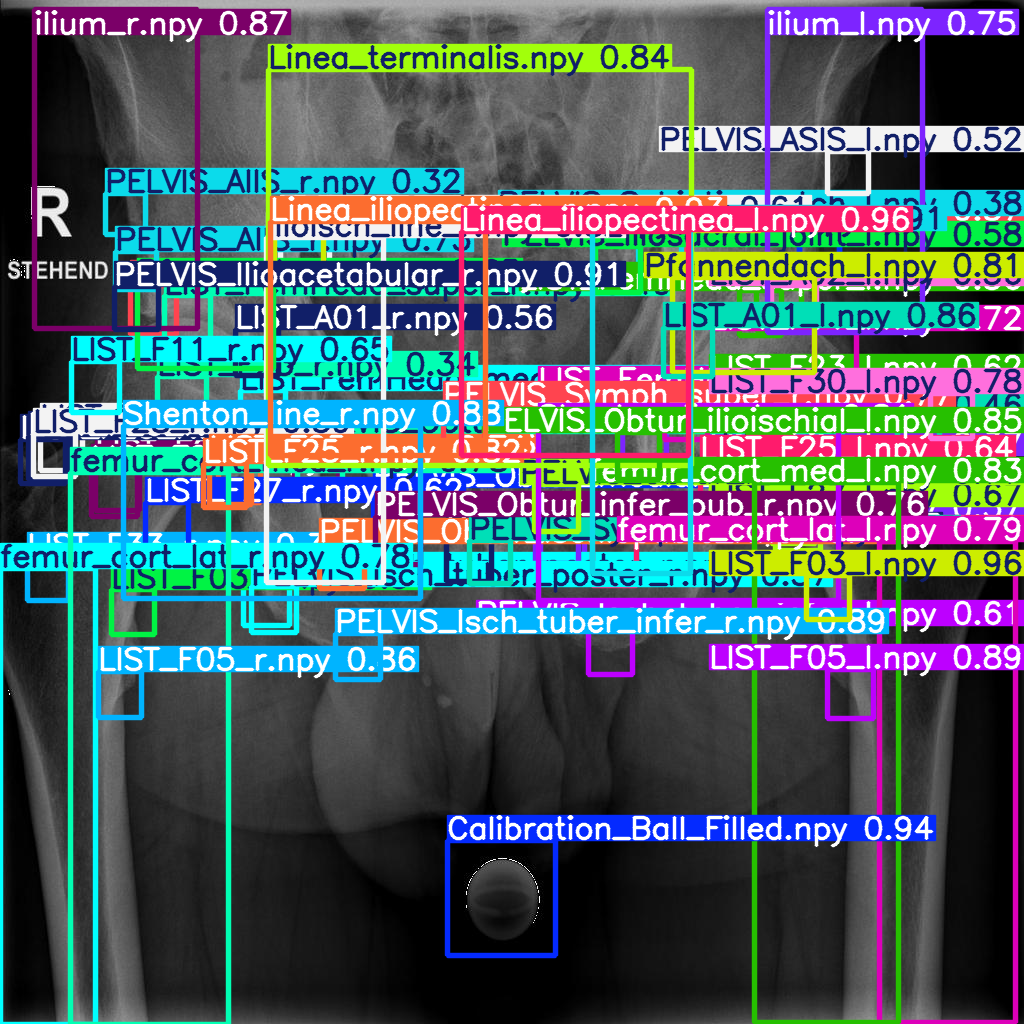

In [20]:
res_083[0].show()

In [21]:
len(res_083[0].summary())

82

In [23]:
res_001 = model('datasets/yolo_full/val/images/001.jpg')


image 1/1 /home/katya/Huggingface/datasets/yolo_full/val/images/001.jpg: 640x640 1 Calibration_Ball_Filled.npy, 1 Ilioisch_line_l.npy, 1 Ilioisch_line_r.npy, 1 LIST_A02_l.npy, 1 LIST_F03_l.npy, 1 LIST_F03_r.npy, 1 LIST_F05_r.npy, 1 LIST_F11_l.npy, 1 LIST_F11_r.npy, 1 LIST_F23_l.npy, 1 LIST_F23_r.npy, 2 LIST_F24_l.npys, 2 LIST_F24_r.npys, 1 LIST_F25_l.npy, 1 LIST_F25_r.npy, 1 LIST_F27_l.npy, 1 LIST_F28_l.npy, 1 LIST_F29_l.npy, 2 LIST_F29_r.npys, 1 LIST_F30_l.npy, 2 LIST_F30_r.npys, 1 LIST_F31_l.npy, 1 LIST_F31_r.npy, 1 LIST_F33_l.npy, 1 LIST_F33_r.npy, 1 LIST_FemHead_med_l.npy, 1 LIST_FemHead_med_r.npy, 2 LIST_FemHead_super_l.npys, 1 LIST_FemHead_super_r.npy, 2 LIST_P01_r.npys, 1 PELVIS_AIIS_r.npy, 1 PELVIS_Ilioacetabular_r.npy, 1 PELVIS_Iliopectineal_l.npy, 1 PELVIS_Iliopectineal_r.npy, 1 PELVIS_Isch_tuber_infer_r.npy, 1 PELVIS_Obtur_ilioischial_l.npy, 1 PELVIS_Obtur_ilioischial_r.npy, 1 PELVIS_Obtur_infer_pub_l.npy, 1 PELVIS_Obtur_infer_pub_r.npy, 2 PELVIS_Obtur_ischiopubic_l.npys, 1

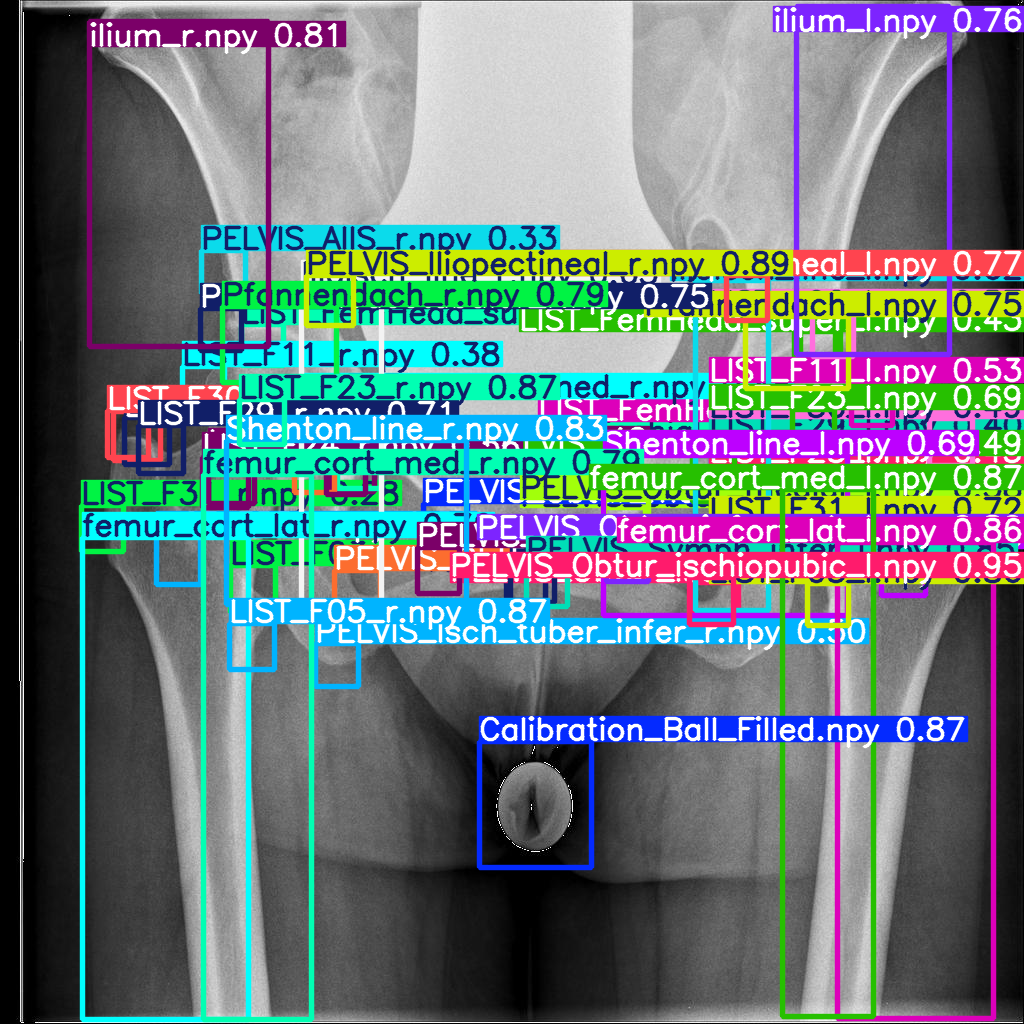

In [24]:
res_001[0].show()

In [26]:
res_json = res_001[0].to_json()
print(res_json)

[
  {
    "name": "PELVIS_Obtur_ischiopubic_l.npy",
    "class": 57,
    "confidence": 0.95436,
    "box": {
      "x1": 689.12366,
      "y1": 577.8551,
      "x2": 733.67383,
      "y2": 624.93402
    }
  },
  {
    "name": "PELVIS_Iliopectineal_r.npy",
    "class": 47,
    "confidence": 0.88762,
    "box": {
      "x1": 306.67865,
      "y1": 275.71124,
      "x2": 353.37146,
      "y2": 325.62814
    }
  },
  {
    "name": "LIST_F05_r.npy",
    "class": 10,
    "confidence": 0.87105,
    "box": {
      "x1": 229.21777,
      "y1": 623.04114,
      "x2": 274.48663,
      "y2": 669.5083
    }
  },
  {
    "name": "Calibration_Ball_Filled.npy",
    "class": 0,
    "confidence": 0.86968,
    "box": {
      "x1": 479.96426,
      "y1": 741.36896,
      "x2": 591.82141,
      "y2": 867.54407
    }
  },
  {
    "name": "femur_cort_med_l.npy",
    "class": 73,
    "confidence": 0.86874,
    "box": {
      "x1": 782.88788,
      "y1": 489.54199,
      "x2": 873.04651,
      "y2": 1016.37366

In [27]:
len(res_001[0].summary())

64

In [28]:
boxes = res_001[0].boxes
boxes.conf

tensor([0.9544, 0.8876, 0.8710, 0.8697, 0.8687, 0.8670, 0.8638, 0.8559, 0.8497, 0.8271, 0.8149, 0.7965, 0.7888, 0.7882, 0.7681, 0.7679, 0.7639, 0.7595, 0.7532, 0.7485, 0.7168, 0.7071, 0.6882, 0.6874, 0.6544, 0.6244, 0.6031, 0.5843, 0.5651, 0.5581, 0.5303, 0.5173, 0.5033, 0.5004, 0.4976, 0.4946, 0.4908, 0.4764, 0.4593,
        0.4509, 0.4454, 0.4264, 0.4239, 0.4082, 0.4028, 0.3996, 0.3991, 0.3806, 0.3796, 0.3554, 0.3344, 0.3334, 0.3303, 0.3257, 0.3239, 0.3029, 0.2875, 0.2855, 0.2824, 0.2817, 0.2813, 0.2799, 0.2590, 0.2531], device='cuda:0')

In [29]:
boxes.data

tensor([[6.8912e+02, 5.7786e+02, 7.3367e+02, 6.2493e+02, 9.5436e-01, 5.7000e+01],
        [3.0668e+02, 2.7571e+02, 3.5337e+02, 3.2563e+02, 8.8762e-01, 4.7000e+01],
        [2.2922e+02, 6.2304e+02, 2.7449e+02, 6.6951e+02, 8.7105e-01, 1.0000e+01],
        [4.7996e+02, 7.4137e+02, 5.9182e+02, 8.6754e+02, 8.6968e-01, 0.0000e+00],
        [7.8289e+02, 4.8954e+02, 8.7305e+02, 1.0164e+03, 8.6874e-01, 7.3000e+01],
        [2.3994e+02, 3.9919e+02, 2.8444e+02, 4.4499e+02, 8.6698e-01, 1.4000e+01],
        [8.0787e+02, 5.8318e+02, 8.4829e+02, 6.2561e+02, 8.6378e-01, 7.0000e+00],
        [8.3797e+02, 5.4268e+02, 9.9392e+02, 1.0188e+03, 8.5586e-01, 7.1000e+01],
        [5.2635e+02, 5.6195e+02, 5.6779e+02, 6.0638e+02, 8.4968e-01, 6.3000e+01],
        [2.2621e+02, 4.4056e+02, 4.6631e+02, 6.0441e+02, 8.2708e-01, 7.0000e+01],
        [8.9985e+01, 2.1183e+01, 2.6877e+02, 3.4679e+02, 8.1494e-01, 7.6000e+01],
        [6.0643e+02, 5.3977e+02, 6.4820e+02, 5.8121e+02, 7.9646e-01, 5.5000e+01],
        [2.0395e

In [30]:
boxes.cls

tensor([57., 47., 10.,  0., 73., 14.,  7., 71., 63., 70., 76., 55., 74., 68., 56., 46., 72., 75., 44., 67., 27., 24., 69., 13.,  2.,  1., 26., 59.,  5., 16., 11., 64., 50., 58., 30., 53., 25., 32., 29., 16., 17., 33., 36., 19., 18., 23., 60., 12., 15., 34., 41., 31., 21., 57., 64., 24., 33., 54., 59., 36., 15., 28.,
         8., 26.], device='cuda:0')

In [31]:
boxes.xyxy

tensor([[ 689.1237,  577.8551,  733.6738,  624.9340],
        [ 306.6786,  275.7112,  353.3715,  325.6281],
        [ 229.2178,  623.0411,  274.4866,  669.5083],
        [ 479.9643,  741.3690,  591.8214,  867.5441],
        [ 782.8879,  489.5420,  873.0465, 1016.3737],
        [ 239.9416,  399.1896,  284.4415,  444.9947],
        [ 807.8675,  583.1834,  848.2929,  625.6063],
        [ 837.9678,  542.6768,  993.9229, 1018.7625],
        [ 526.3469,  561.9537,  567.7865,  606.3807],
        [ 226.2128,  440.5571,  466.3103,  604.4107],
        [  89.9846,   21.1826,  268.7714,  346.7907],
        [ 606.4340,  539.7650,  648.2001,  581.2076],
        [ 203.9499,  474.0372,  311.8152, 1019.4079],
        [ 222.2056,  306.4617,  336.8227,  382.6817],
        [ 417.2392,  547.6327,  459.3354,  593.8855],
        [ 726.5380,  275.0520,  767.8622,  320.6783],
        [  82.5574,  537.2379,  248.0588, 1019.3071],
        [ 796.7041,    6.6216,  949.9459,  354.6211],
        [ 200.4496,  308.301

In [33]:
import numpy as np
orig_boxes = {}
with open('datasets/yolo_full/val/labels/001.txt') as f:
    for line in f.readlines():
        arr = line.split()
        orig_boxes[arr[0]] = np.array([float(x) for x in arr[1:]])*1024
#orig_boxes

In [22]:
orig_boxes

{'1': array([        719,         327,          73,         325]),
 '2': array([        362,         358,         102,         302]),
 '3': array([        723,         275,          36,          40]),
 '4': array([        339,         299,          37,          44]),
 '5': array([        821,         228,          42,          44]),
 '6': array([        219,         311,          35,          44]),
 '7': array([        838,         459,          36,          41]),
 '8': array([        250,         541,          41,          44]),
 '9': array([        846,         514,          32,          45]),
 '10': array([        231,         617,          35,          41]),
 '11': array([        843,         274,          37,          43]),
 '12': array([        232,         375,          42,          43]),
 '13': array([        788,         309,          33,          35]),
 '14': array([        277,         370,          45,          45]),
 '15': array([        849,         355,          40,     

In [ ]:
def get_iou(bb1, bb2):
   
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

  
    x_right = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_left = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_left < x_right or y_bottom < y_top:
        return 0.0


    intersection_area = (x_left - x_right) * (y_bottom - y_top)

 
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

   
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou